In [ ]:
# INSTALL LIBRARY
!pip install kaggle
!pip install split-folders

In [5]:
# import library
import zipfile
import splitfolders
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import json
import random
from matplotlib.image import imread
import pandas as pd
from google.colab import files

In [ ]:
# Upload kaggle.json (via menu upload di Colab)
files.upload()

# Pindahkan ke folder yang benar dan set permission
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# DOWNLOAD DAN UNZIP DATASET
!kaggle datasets download -d vencerlanz09/agricultural-pests-image-dataset

with zipfile.ZipFile("agricultural-pests-image-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("pests_dataset")

Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset
License(s): copyright-authors
 91% 93.0M/102M [00:00<00:00, 971MB/s]
100% 102M/102M [00:00<00:00, 972MB/s] 


In [ ]:
# LOAD DATASET DAN MENAMPILKAN NAMA-NAMA KELAS
dataset_path = "pests_dataset"
print(os.listdir(dataset_path))

['grasshopper', 'weevil', 'earthworms', 'bees', 'earwig', 'slug', 'ants', 'wasp', 'beetle', 'catterpillar', 'moth', 'snail']


In [ ]:
# PEMBAGIAN DATA SET 70% train, 20% val, 10% test
splitfolders.ratio(dataset_path, output="data_split", seed=42, ratio=(.7, .2, .1))

Copying files: 5494 files [00:00, 5914.18 files/s]


In [ ]:
# DEFINISI VARIABEL
IMG_SIZE = (224, 224) # MENGUBAH SIZE GAMBAR MENJADI 128X128 PIXEL
BATCH_SIZE = 32       # MENENTUKAN BLA BLA
SEED = 42
BASE_DIR = 'data_split'

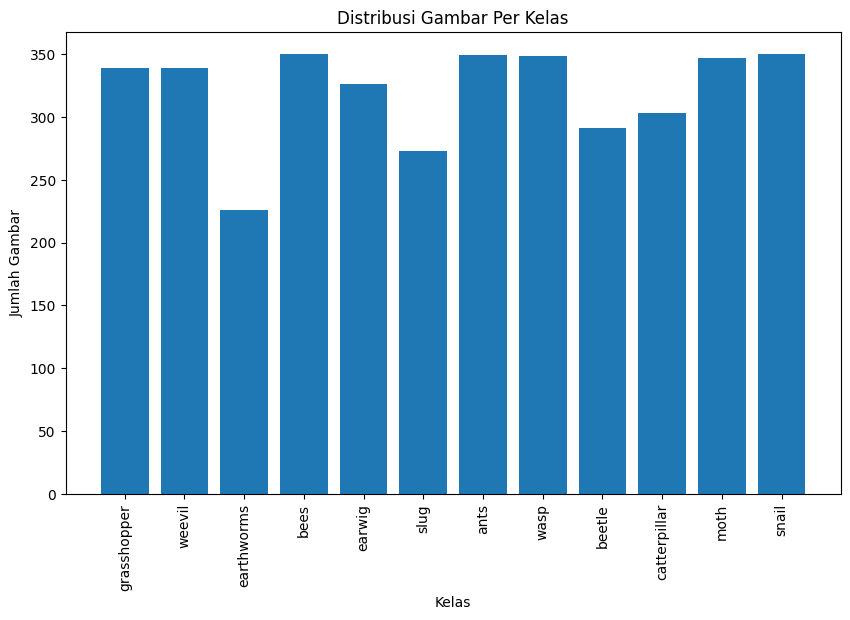

In [ ]:
# Path ke folder dataset
train_dir = os.path.join(BASE_DIR, 'train')

# Ambil semua nama folder kelas
class_names = os.listdir(train_dir)

# Hitung jumlah gambar di setiap kelas
class_counts = [len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names]

# Plot distribusi gambar per kelas
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Gambar Per Kelas')
plt.xticks(rotation=90)
plt.show()

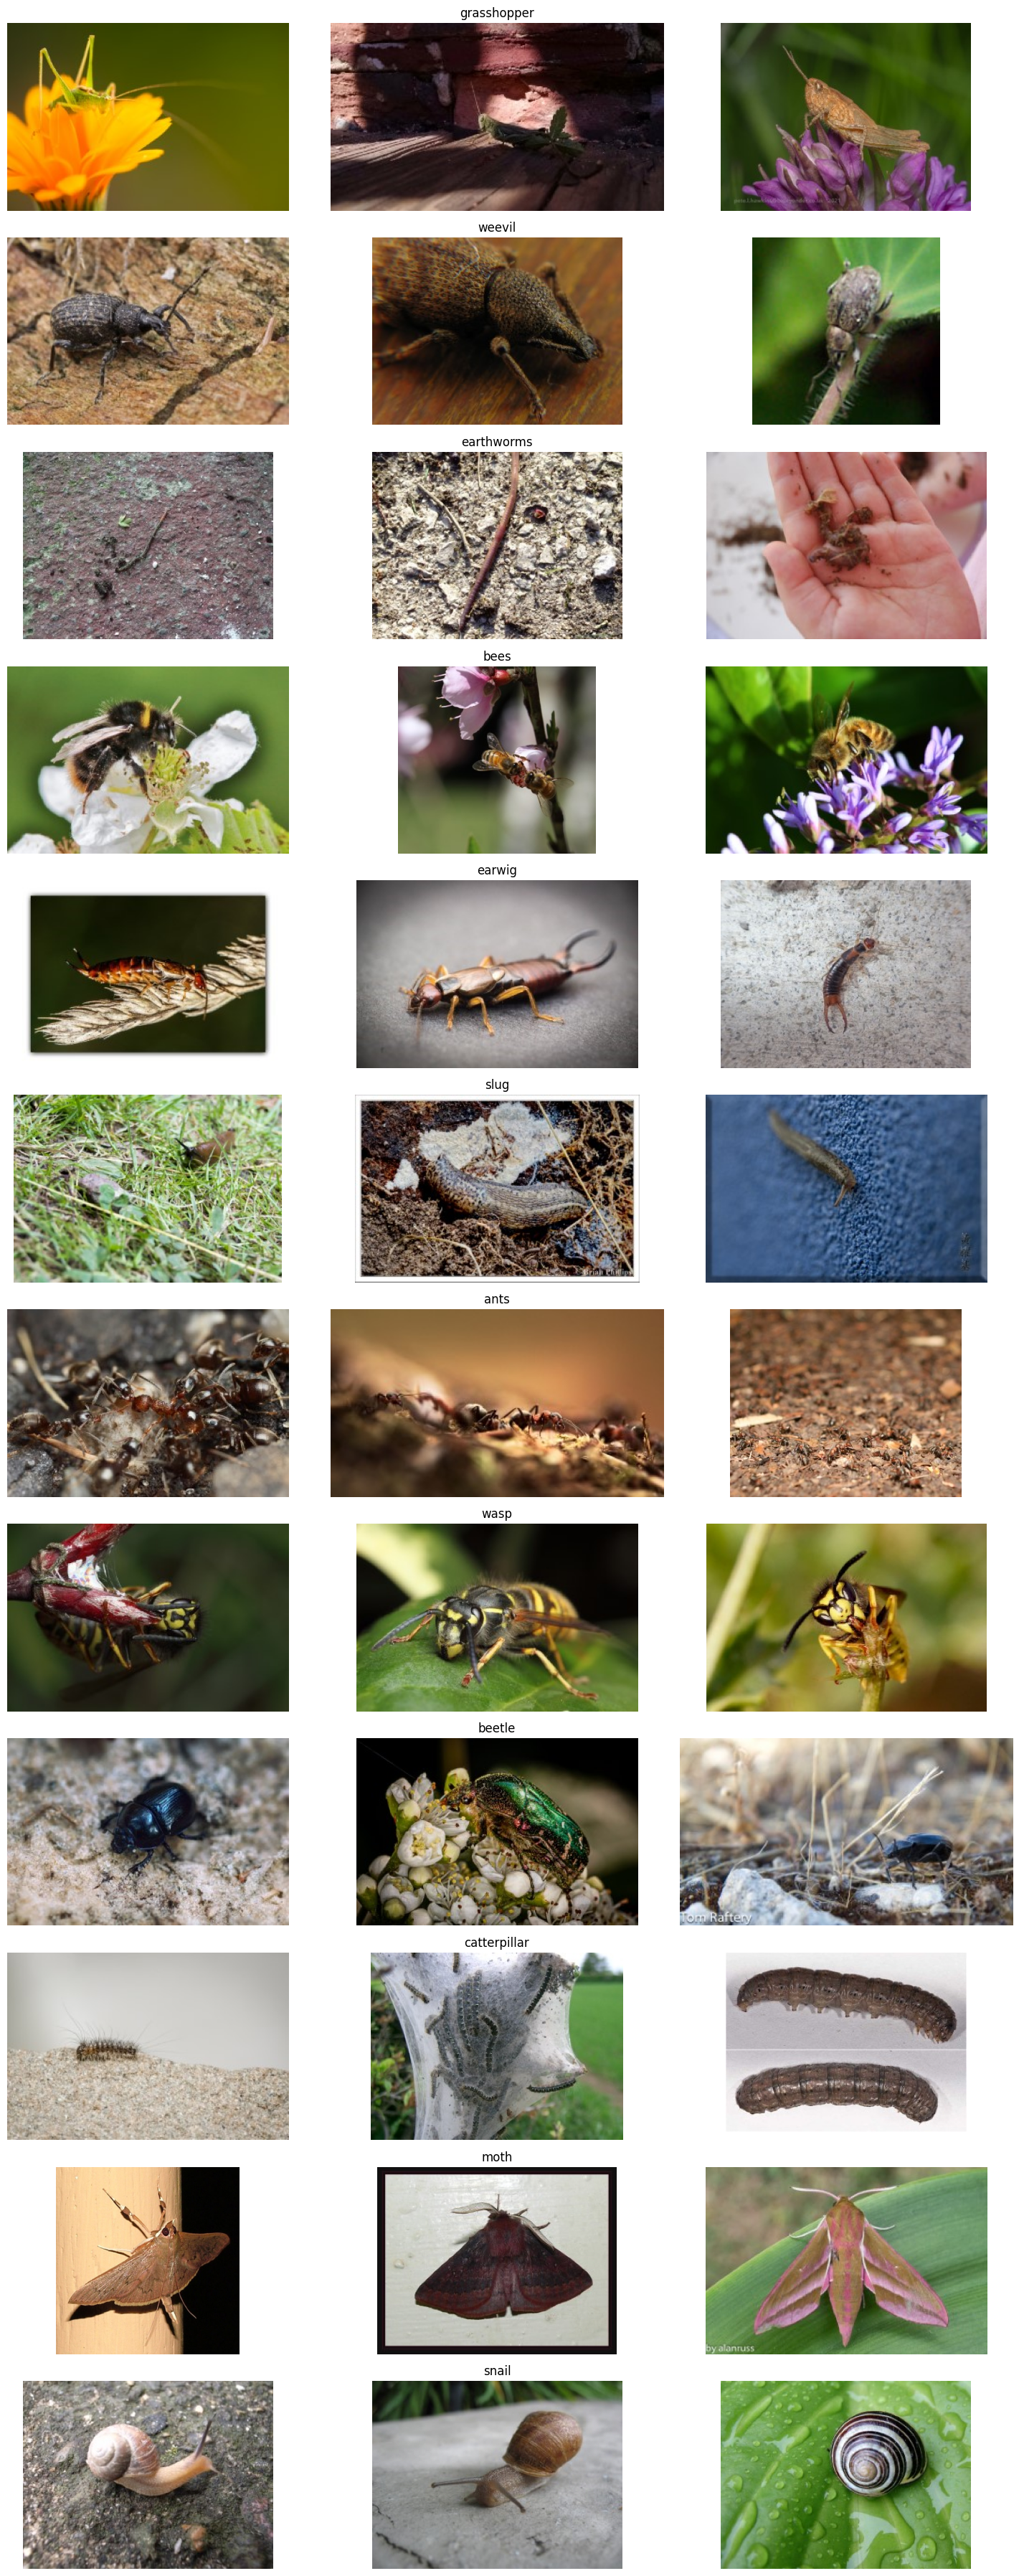

In [ ]:
# Menampilkan 3 gambar per kelas dari folder train
plt.figure(figsize=(15, len(class_names)*3))

for i, class_name in enumerate(class_names):
    class_folder = os.path.join(train_dir, class_name)
    images = os.listdir(class_folder)
    selected_images = random.sample(images, 3)  # ambil 3 gambar acak

    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(class_folder, img_name)
        img = imread(img_path)

        plt.subplot(len(class_names), 3, i*3 + j + 1)
        plt.imshow(img)
        plt.axis('off')

        if j == 1:
            plt.title(class_name, fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# DATA AUGMENTATION
train_aug = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2]
)

val_aug = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = train_aug.flow_from_directory(
    os.path.join(BASE_DIR, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

val_gen = val_aug.flow_from_directory(
    os.path.join(BASE_DIR, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

test_gen = val_aug.flow_from_directory(
    os.path.join(BASE_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

Found 3841 images belonging to 12 classes.
Found 1095 images belonging to 12 classes.
Found 558 images belonging to 12 classes.


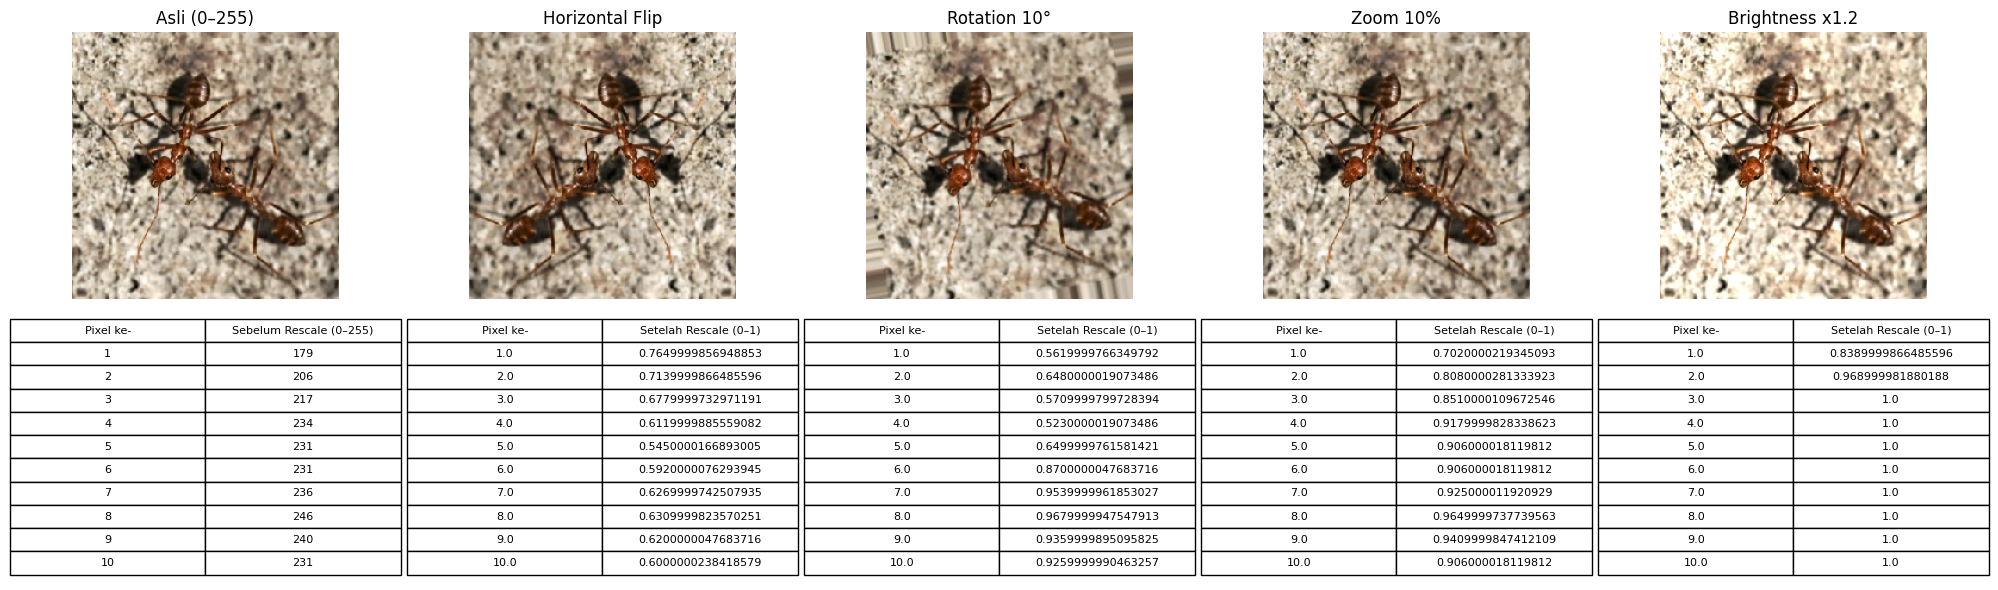

In [ ]:
# Ambil satu gambar dari file asli
img_path = train_gen.filepaths[0]
original_img = load_img(img_path, target_size=IMG_SIZE)
original_array = img_to_array(original_img)  # dtype uint8 (0–255)

# Buat fungsi bantu untuk tampilkan gambar + tabel piksel
def show_image_with_pixels(ax_img, ax_table, image, title):
    ax_img.imshow(image.astype(np.float32) if image.max() <= 1 else image.astype(np.uint8))
    ax_img.set_title(title)
    ax_img.axis("off")

    # Flatten image & ambil channel merah
    flat = image.reshape(-1, 3)
    red_values = flat[:10, 0]

    # Jika gambar direscale, maka max-nya <= 1
    is_rescaled = red_values.max() <= 1.0
    col_label = "Setelah Rescale (0–1)" if is_rescaled else "Sebelum Rescale (0–255)"

    # Buat tabel piksel
    df_pixels = pd.DataFrame({
        "Pixel ke-": list(range(1, 11)),
        col_label: np.round(red_values, 3) if is_rescaled else red_values.astype(int)
    })

    ax_table.axis("off")
    table = ax_table.table(cellText=df_pixels.values,
                           colLabels=df_pixels.columns,
                           cellLoc='center',
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.1, 1.1)

# === Augmentasi manual ===
# Semua akan direscale setelah augmentasi
augmentations = {
    "Horizontal Flip": dict(flip_horizontal=True),
    "Rotation 10°": dict(theta=10),
    "Zoom 10%": dict(zoom=(1.1, 1.1)),
    "Brightness x1.2": dict(brightness=1.2),
}

# Generator dasar
datagen = ImageDataGenerator(rescale=1./255)

# Buat subplot: 2 baris (gambar + tabel), 5 kolom (asli + 4 augmentasi)
fig, axes = plt.subplots(2, 5, figsize=(20, 6))

# Gambar asli
show_image_with_pixels(axes[0, 0], axes[1, 0], original_array, "Asli (0–255)")

# Tampilkan semua jenis augmentasi dari gambar yang sama
for i, (aug_name, transform_dict) in enumerate(augmentations.items(), start=1):
    # Apply transform ke gambar asli
    augmented = datagen.apply_transform(original_array.copy(), transform_dict)
    augmented = augmented / 255.0  # Apply rescale manually agar konsisten

    show_image_with_pixels(axes[0, i], axes[1, i], augmented, aug_name)

plt.tight_layout()
plt.show()

## MODELING

In [ ]:
# TRANSFER LEARNING MODEL
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# CALLBACKS
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [ ]:
# TRAINING
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, lr_reduce]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - accuracy: 0.2938 - loss: 2.2745 - val_accuracy: 0.7160 - val_loss: 0.8748 - learning_rate: 1.0000e-04
Epoch 2/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.7508 - loss: 0.8022 - val_accuracy: 0.7991 - val_loss: 0.6890 - learning_rate: 1.0000e-04
Epoch 3/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.8104 - loss: 0.5917 - val_accuracy: 0.8356 - val_loss: 0.5694 - learning_rate: 1.0000e-04
Epoch 4/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.8377 - loss: 0.5013 - val_accuracy: 0.8347 - val_loss: 0.5996 - learning_rate: 1.0000e-04
Epoch 5/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.8744 - loss: 0.3915 - val_accuracy: 0.8447 - val_loss: 0.5332 - learning_rate: 1.0000e-04
Epoch 6/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.8877 - loss: 0.3488 - val_accuracy: 0.8594 - val_loss: 0.4984 - learning_rate: 1.0000e-04
Epoch 7/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - acc

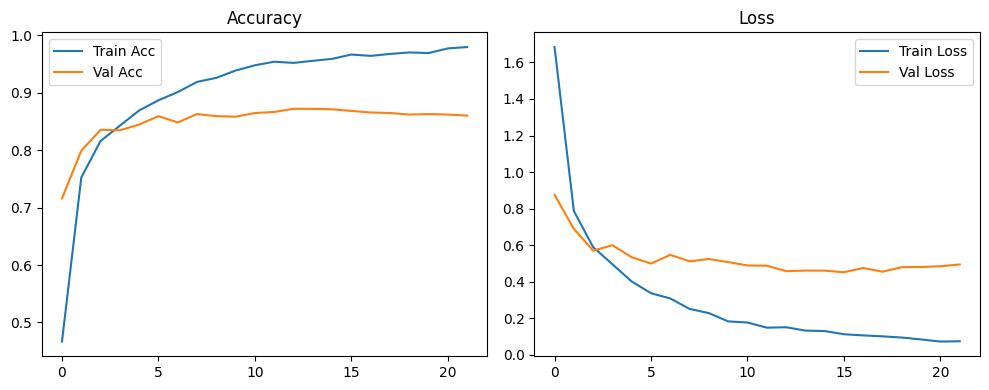

In [ ]:
# VISUALIZATION
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()

In [ ]:
# CETAK AKURASI & LOSS TRAINING/VALIDASI
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"\nAkurasi Data Training: {train_acc:.4f}")
print(f"Akurasi Data Validasi: {val_acc:.4f}")
print(f"Loss Data Training   : {train_loss:.4f}")
print(f"Loss Data Validasi   : {val_loss:.4f}")


Akurasi Data Training: 0.9797
Akurasi Data Validasi: 0.8603
Loss Data Training   : 0.0730
Loss Data Validasi   : 0.4937


In [ ]:
# EVALUATION
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.4f} - Test Loss: {loss:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8895 - loss: 0.3734
Test Accuracy: 0.9014 - Test Loss: 0.3350


18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

Classification Report:
              precision    recall  f1-score   support

        ants       0.96      0.94      0.95        51
        bees       0.90      0.94      0.92        50
      beetle       0.74      0.74      0.74        42
catterpillar       0.76      0.78      0.77        45
  earthworms       0.82      0.85      0.84        33
      earwig       0.82      0.89      0.86        47
 grasshopper       0.98      0.84      0.90        49
        moth       0.98      1.00      0.99        51
        slug       0.85      0.82      0.84        40
       snail       1.00      0.98      0.99        50
        wasp       0.96      1.00      0.98        51
      weevil       0.98      0.96      0.97        49

    accuracy                           0.90       558
   macro avg       0.90      0.90      0.89       558
weighted avg       0.90      0.90      0.90       558



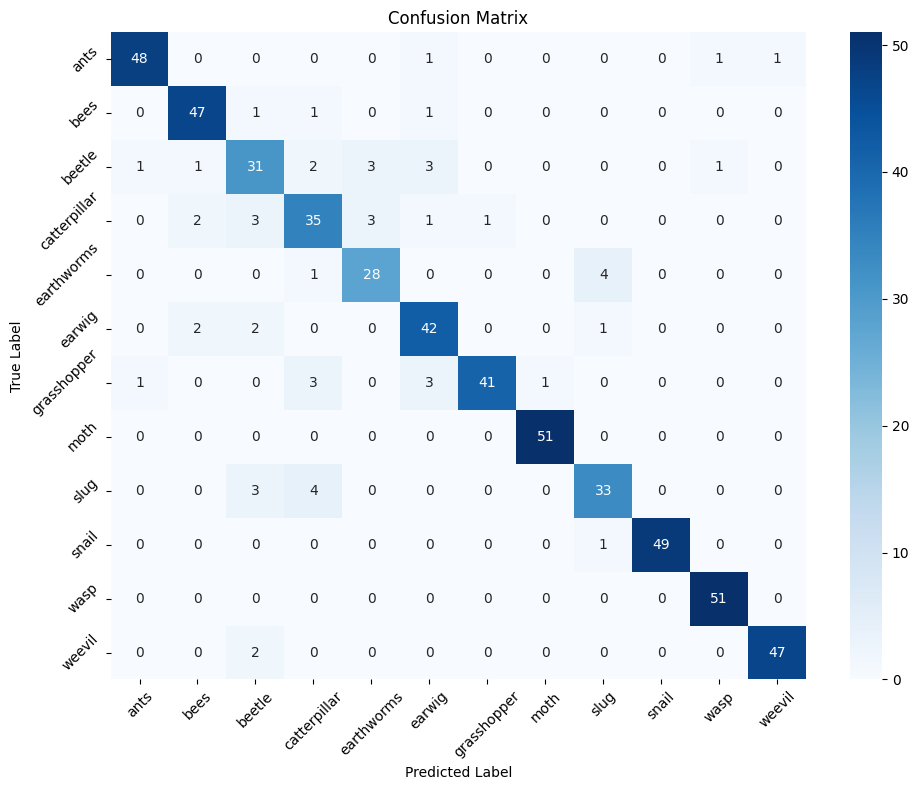

In [ ]:
# Ambil prediksi di test data
test_steps = test_gen.samples // test_gen.batch_size + 1
pred_probs = model.predict(test_gen, steps=test_steps)
pred_classes = np.argmax(pred_probs, axis=1)

# Label sebenarnya
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Simpan class_indices
class_labels = list(train_gen.class_indices.keys())
with open('class_labels.json', 'w') as f:
    json.dump(class_labels, f)

# Simpan model
model.save('model_hama.h5')

In [15]:
# Upload gambar dari lokal
uploaded = files.upload()

# Ambil nama file gambar
for filename in uploaded.keys():
    img_path = filename

Saving snail.jpg to snail.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


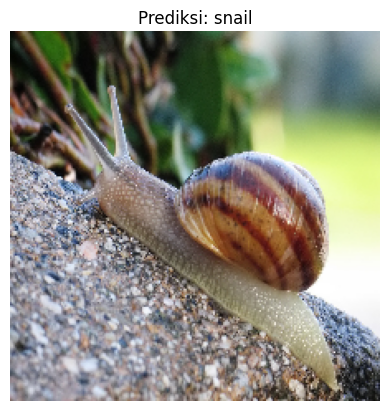

In [16]:
# Load model
model = load_model('/content/model_hama.h5')

# Load label list dari JSON
with open('/content/class_labels.json', 'r') as f:
    label_list = json.load(f)  # ['ants', 'bees', ...]

# Buat mapping dari index ke label
label_map = {i: label for i, label in enumerate(label_list)}

# Preprocessing gambar
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_label = label_map[predicted_class_index]

# Tampilkan hasil
plt.imshow(img)
plt.title(f'Prediksi: {predicted_label}')
plt.axis('off')
plt.show()